In [1]:
import tensorflow as tf
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE

In [2]:
# Check if GPU is available
print(tf.test.gpu_device_name())

/device:GPU:0


In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

- The following study presents a model for generating chest X-ray images of normal subjects (without lung disease) and pneumonia patients.
- Through the proposed model, I tried to avoid most of the problems that the GAN models suffer from, in terms of the difficulty of training each of the generator and the discriminant, in addition to the problem of the modal collapse and the perceptual quality, so that I tried through the proposed model, to try to continue the training (to ensure the continuity of the derivability of cost function ) and discovering the features by the discriminator (the most accurate features for each case of the dataset), which leads the generator to focus on them during the training process.
- A conditional model was used for the GAN, and the discriminator was forced to determine whether the medical images are real or not, in addition to identifying the pathological condition in the generated images.
- I used (64, 64, 3) images because I didn't have enough computational resources.
- I used Google Colab For Training.
- Reading the images included in the dataset, which is for the sound health condition, and the other case, which is pneumonia.
- I have included all medical images included in each class, although the number of samples per class varies (thus this would require training for a higher number of Epochs for the GAN).

In [17]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img))
                img = cv2.resize(img, self.image_shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img  = img/255
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [18]:
readDatasetObject = ReadDataset('chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))

In [19]:
images, labels = readDatasetObject.readImages()

In [64]:
images.shape, labels.shape

((5216, 64, 64, 3), (5216,))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


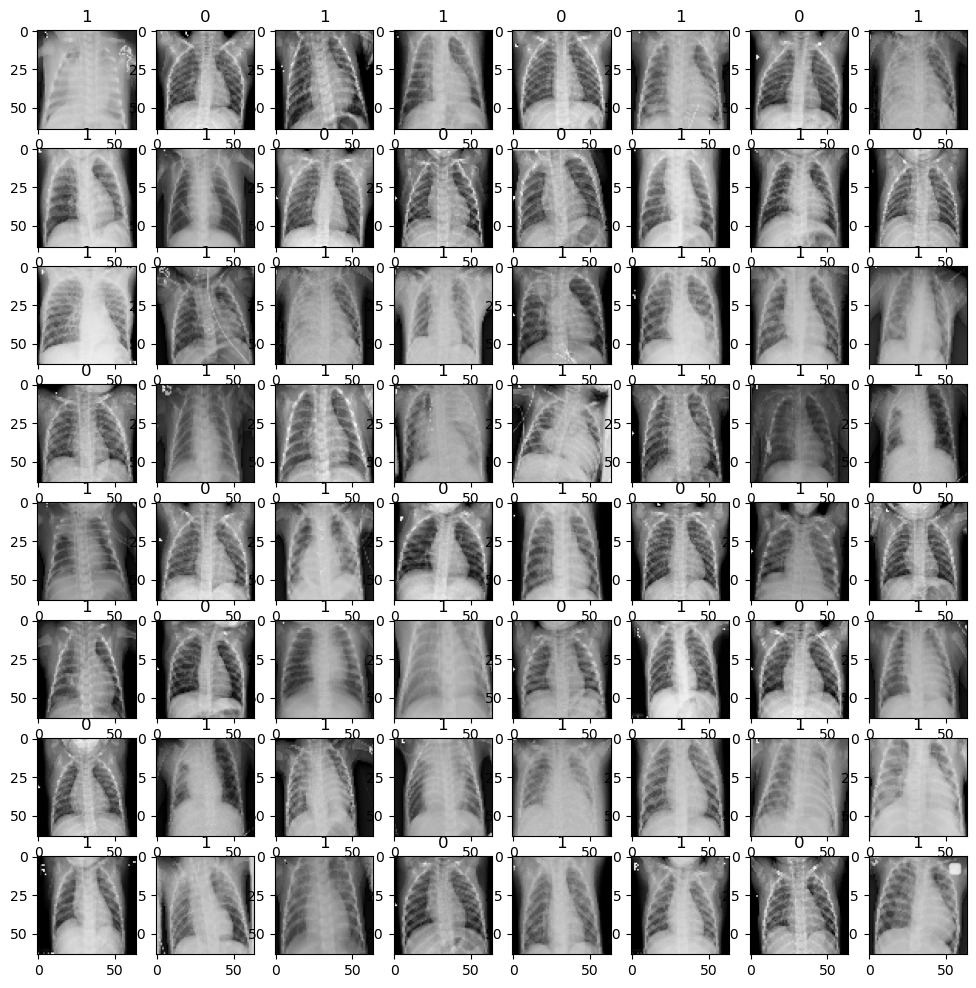

In [10]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]])
    plt.title(labels[indexs[i]])
plt.legend()

In [65]:
smote = SMOTE()
images_flat = images.reshape(images.shape[0], -1)
images_resampled, labels_resampled = smote.fit_resample(images_flat, labels)
images_resampled = images_resampled.reshape(-1, 64, 64, 3)

In [66]:
data_gen_args = dict(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
augmented_data_generator = image_datagen.flow(images_resampled, labels_resampled, batch_size=64)

Sample images included in the dataset for each class

- The proposed generative adversarial network, so that the difficulty of training and many of the problems that can be encountered in the generative adversarial network can be avoided, such as postural collapse and cognitive quality.

- The structure focused on including many structures that helped some of them to avoid falling into the problem of situational collapse, and the other structures focused on perceptual quality (as it forced the distinguished network to focus more on the deeper features in the medical images, which helped the generator to capture them in the generation process).

- The architecture helped make the training balanced between both the Generator and the Discriminator.

- Conditional generation was used, whereby the Discriminator was forced to verify that the generated images were real, class-following (a healthy person, or a person with pneumonia).

- The generator's input was a noise with a regular distribution, in addition to the pathological condition that we want to classify.
- Use the MSE loss function to address the problem of cognitive quality and make the generator focus on the health characteristics of a healthy person, and the pathological characteristics of a person suffering from pneumonia.

In [60]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size

    def data(self, augmented_data_generator):
        self.augmented_data_generator = augmented_data_generator
        
    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis=1)
        plt.figure(figsize=(12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i])
            plt.title(ys[i])
        plt.show()

    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024)(x)
        x = layers.Dropout(0.5)(x)  # Added dropout for regularization
        x = layers.Dense(8 * 8 * filters[0],
                         kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size=self.kernel_size, padding=padding,
                                strides=strides)(x)
            x = layers.Dropout(0.5)(x)  # Added dropout for regularization
        x = Conv2DTranspose(3, kernel_size=self.kernel_size, padding=padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs=[inputs, labels],
                                           outputs=x,
                                           name='generator')

    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size=self.kernel_size, padding=padding,
                       strides=strides,
                       kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = layers.Dropout(0.5)(x)  # Added dropout for regularization
        x = layers.Flatten()(x)
        outputs = Dense(1)(x)
        labelsOutput = Dense(256,
                             kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs=inputs,
                                               outputs=[outputs, labelsOutput],
                                               name='discriminator')
    def build(self):
        generatorInput = layers.Input(shape=(self.latent_space))
        discriminatorInput = layers.Input(shape=(self.image_shape))
        labelsInput = layers.Input(shape=(2, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel

        # Using binary_crossentropy for both outputs of the discriminator
        D.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta))

        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs=[generatorInput, labelsInput],
                        outputs=D(G([generatorInput, labelsInput])))

        # Using binary_crossentropy for both outputs of the GAN model
        GAN.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
                    optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta))

        GAN.summary()
        return G, D, GAN

    def trainAlgorithm(self, G, D, GAN):
        save_interval = 1000  # or whatever interval you prefer
        # Assuming you have an augmented_data_generator defined in the data method
        for epoch in range(self.epochs):
            # Get a batch of augmented and balanced data
            realImages, realLabels = next(self.augmented_data_generator)
            # Ensure realLabels is one-hot encoded
            if len(realLabels.shape) == 1 or realLabels.shape[1] != 2:
                realLabels = tf.keras.utils.to_categorical(realLabels, num_classes=2)

            realTag = tf.ones(shape=(realLabels.shape[0],))
            noize = tf.random.uniform(shape=(realLabels.shape[0], self.latent_space), minval=-1, maxval=1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size=(realLabels.shape[0],)), num_classes=2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose=0))
            fakeTag = tf.zeros(shape=(realLabels.shape[0],))
            
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            
            if epoch % 5000 == 0:
                print('Epoch:', epoch)
                print('Discriminator loss: [tag: {}, labels: {}], Generator loss: [tag: {}, labels: {}]'.format(dlossTag, dlossLabels, glossTag, glossLabels))
                self.samples(G, noize, fakeLabels)
                
            # Save model weights every save_interval epochs
            if epoch % save_interval == 1000:
                G.save_weights('generator_weights_epoch_{}.h5'.format(epoch))
                D.save_weights('discriminator_weights_epoch_{}.h5'.format(epoch))

- In order to avoid falling into the problem of mode collapse, a smaller number of samples was used to be passed each time to the generative adversarial network.
- It helped reduce the number of samples that are passed to the obstetric adversarial network, until the generator collects more accurately the areas that affect the presence of pneumonia in the patient, as well as the healthy condition.

- Because I didn't have much computational resources, not many Epochs were used.

- Since we are dealing with a pathological condition, the use of kernel_size in a larger size helps to study the relationship between the core regions and the surrounding areas, and the possibility of the existence of gradients that express the pathological condition or the healthy condition. (That is, it helps to determine whether an area, according to its location, can be suitable as a criterion for the presence of pneumonia, or not).
- Using LayerNormalization instead of BatchNormalization was very useful in diversifying the images that the generator generates and not falling into mode collapse (since LayerNormalization does the normalization at the level of the filters included in the layer).

In [61]:
acgan = Acgan(eta=0.0001, batch_size=128, epochs=32000, 
              latent_space=100, image_shape=(64, 64, 3), kernel_size=5)

In [62]:
acgan.data(augmented_data_generator)

In [63]:
G, D, GAN = acgan.build()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 32, 32)   2432        ['input_17[0][0]']               
                                                                                                  
 leaky_re_lu_20 (LeakyReLU)     (None, 32, 32, 32)   0           ['conv2d_20[0][0]']              
                                                                                                  
 dropout_55 (Dropout)           (None, 32, 32, 32)   0           ['leaky_re_lu_20[0][0]']         
                                                                                      

 nspose)                                                                                          
                                                                                                  
 dropout_51 (Dropout)           (None, 16, 16, 256)  0           ['conv2d_transpose_25[0][0]']    
                                                                                                  
 layer_normalization_21 (LayerN  (None, 16, 16, 256)  512        ['dropout_51[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_31 (Activation)     (None, 16, 16, 256)  0           ['layer_normalization_21[0][0]'] 
                                                                                                  
 conv2d_transpose_26 (Conv2DTra  (None, 32, 32, 128)  819328     ['activation_31[0][0]']          
 nspose)  

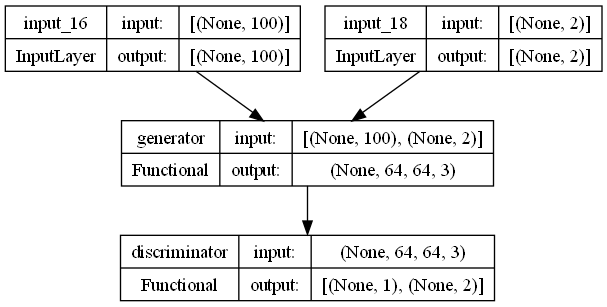

In [64]:
tf.keras.utils.plot_model(GAN, show_shapes = True)

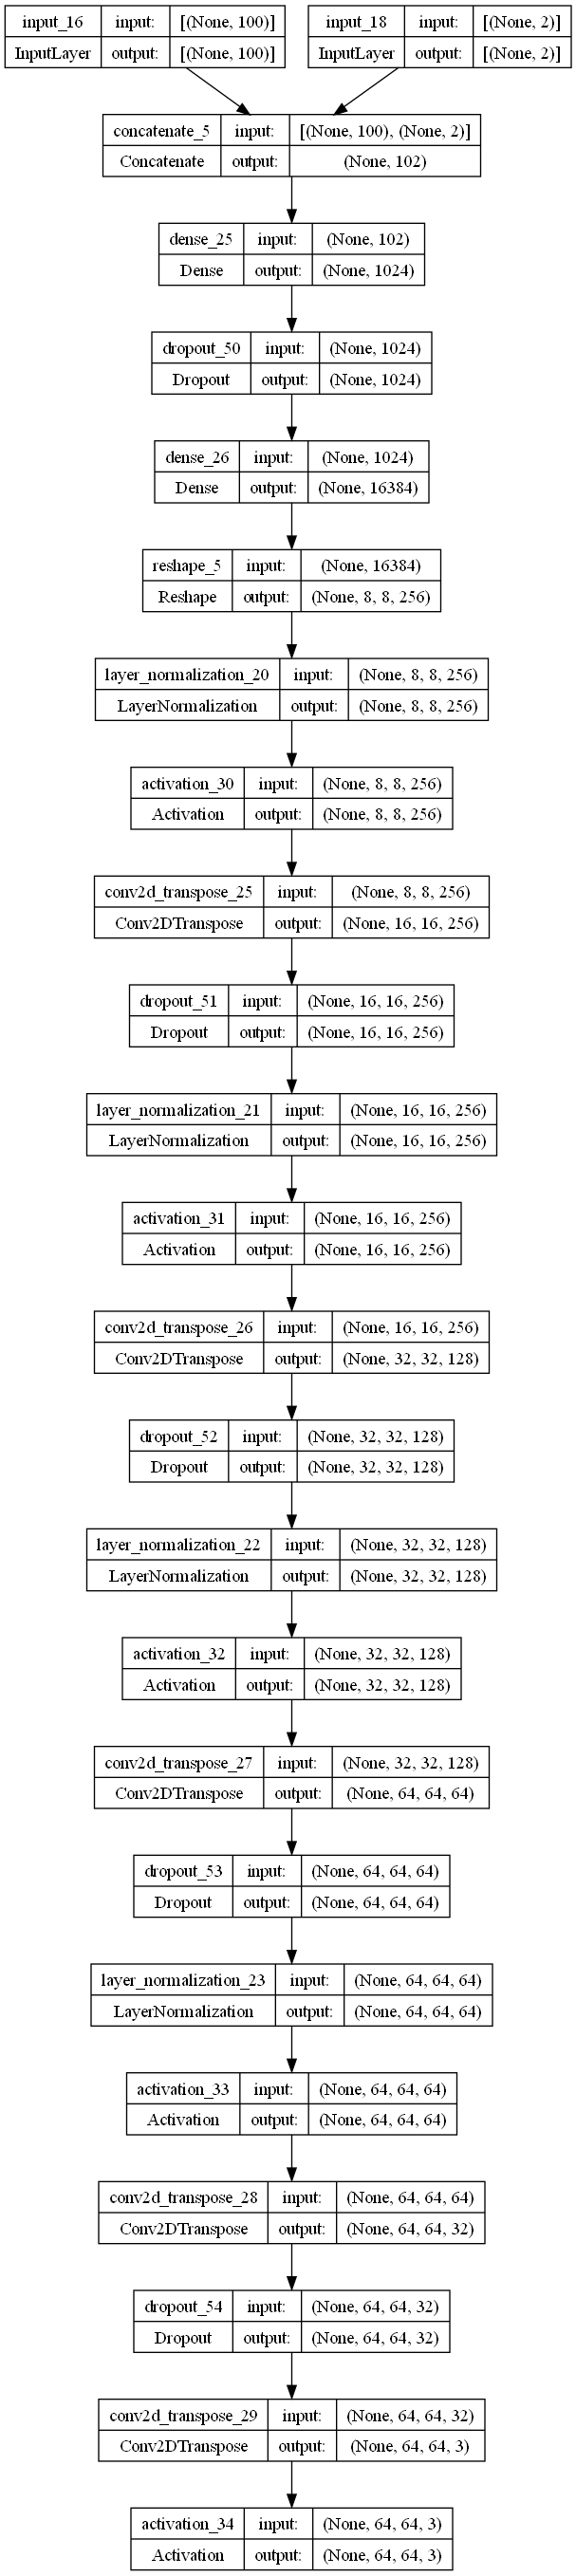

In [65]:
tf.keras.utils.plot_model(G, show_shapes = True)

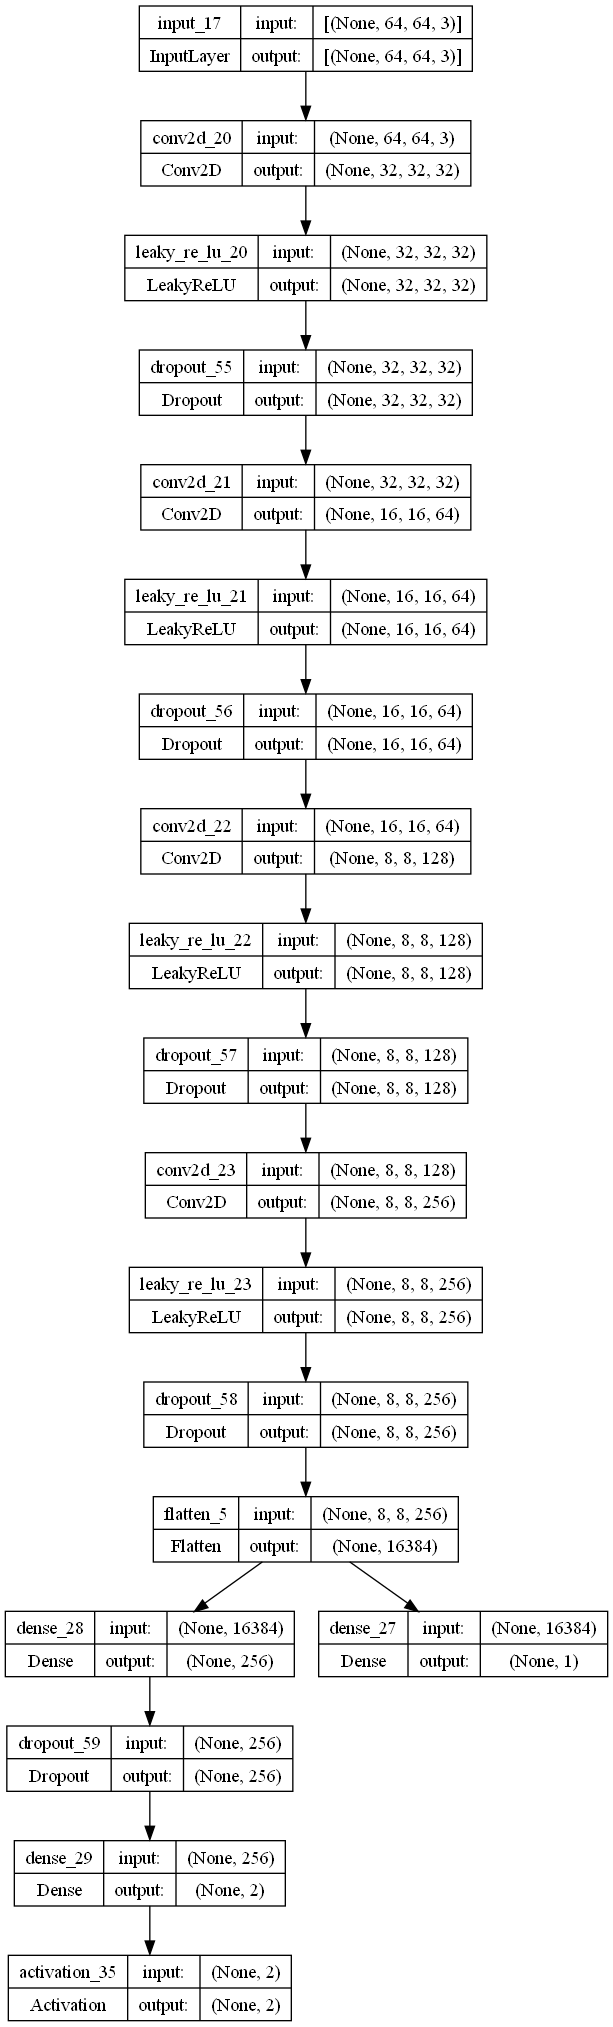

In [66]:
tf.keras.utils.plot_model(D, show_shapes = True)

Epoch: 0
Discriminator loss: [tag: 4.350347518920898, labels: 0.6896167397499084], Generator loss: [tag: 1.2831158638000488, labels: 0.7935552597045898]
2/2 [==============================] - 0s 25ms/step


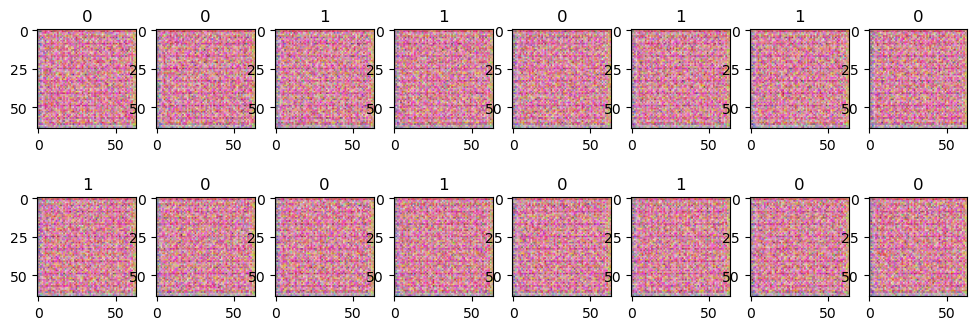

Epoch: 5000
Discriminator loss: [tag: 0.3611697852611542, labels: 0.0747847855091095], Generator loss: [tag: 0.5315833687782288, labels: 0.0011084610596299171]
2/2 [==============================] - 0s 16ms/step


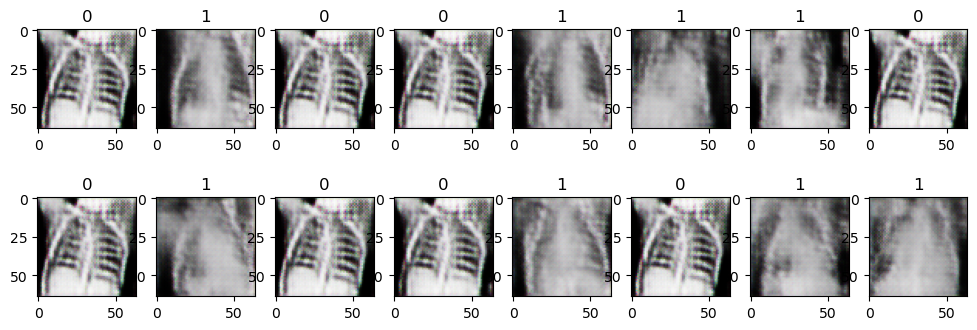

Epoch: 10000
Discriminator loss: [tag: 0.3738906979560852, labels: 0.11210362613201141], Generator loss: [tag: 0.5421265363693237, labels: 0.0030646587256342173]
2/2 [==============================] - 0s 15ms/step


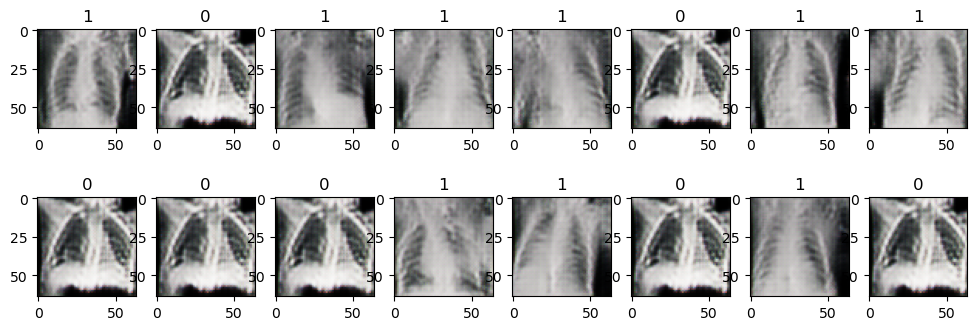

Epoch: 15000
Discriminator loss: [tag: 0.39036989212036133, labels: 0.09206049889326096], Generator loss: [tag: 0.5322836637496948, labels: 0.0006376770325005054]
2/2 [==============================] - 0s 15ms/step


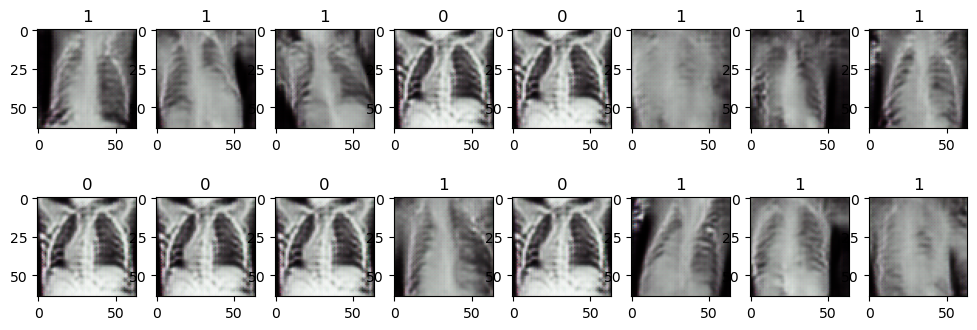

Epoch: 20000
Discriminator loss: [tag: 0.49306049942970276, labels: 0.10983319580554962], Generator loss: [tag: 0.48963266611099243, labels: 0.0017023978289216757]
2/2 [==============================] - 0s 16ms/step


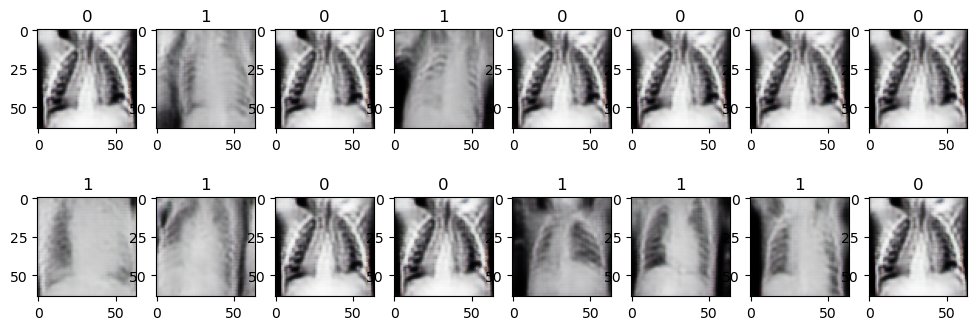

Epoch: 25000
Discriminator loss: [tag: 0.3610495626926422, labels: 0.08360089361667633], Generator loss: [tag: 0.5249466896057129, labels: 0.0004988627624697983]
2/2 [==============================] - 0s 15ms/step


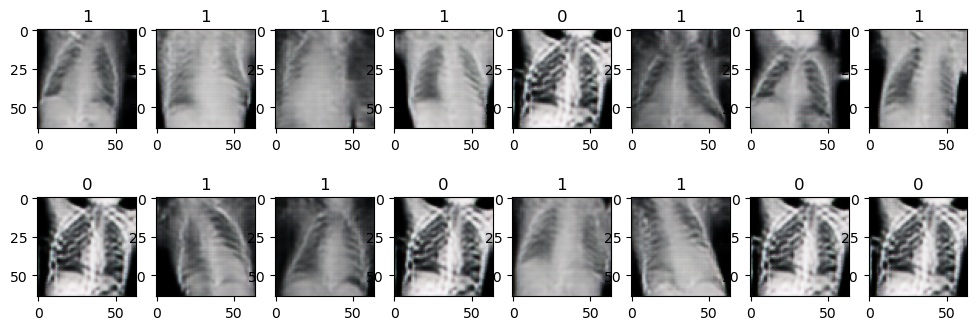

Epoch: 30000
Discriminator loss: [tag: 0.5126365423202515, labels: 0.08138077706098557], Generator loss: [tag: 0.5304501056671143, labels: 0.0009997050510719419]
2/2 [==============================] - 0s 15ms/step


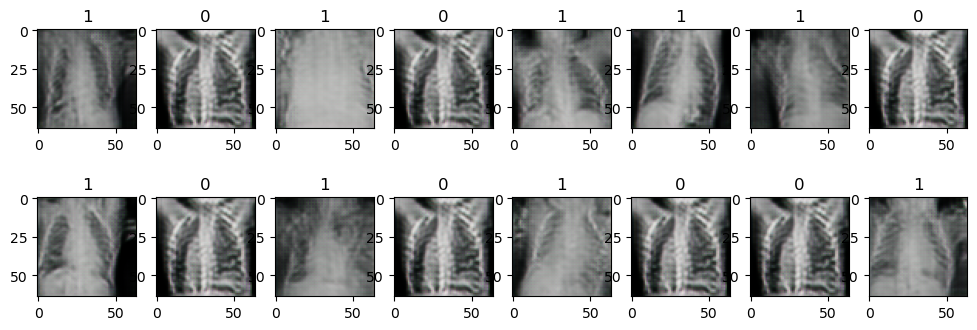

In [67]:
with tf.device('/GPU:0'):
    acgan.trainAlgorithm(G, D, GAN)

In [ ]:
G.save('/kaggle/working/generator.h5')

In [3]:
G = tf.keras.models.load_model('/kaggle/working/generator.h5')

- We have to make sure that the images that the generator generates are correct, and that they actually include pathological conditions, and this is done by generating a large number of samples, using a neural network to classify the images, and then using the trained neural network, in order to classify the basic images that are included in the basic dataset.

In [4]:
datasetGenerationSize = 30000
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [5]:
noize.shape, newlabels.shape

(TensorShape([30000, 100]), (30000, 2))

In [6]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1], dtype=int64), array([15059, 14941], dtype=int64))

In [7]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

938/938 [==============================] - 22s 16ms/step


(30000, 64, 64, 3)

- Samples generated by the generator for each case (healthy person, person with pneumonia).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


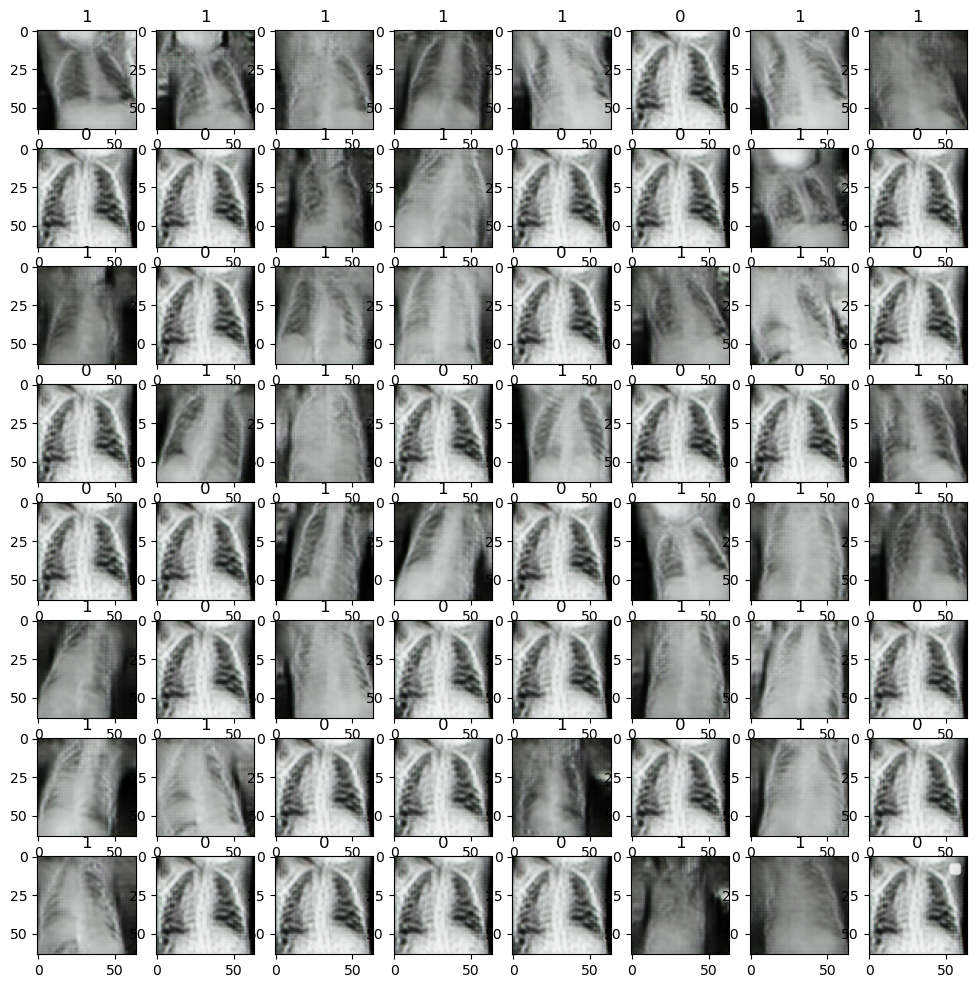

In [8]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesGeneration[i])
    plt.title(t[i])
plt.legend()

In order to be able to evaluate the images generated by the generating neural network, we can do so by proposing a neural structure dedicated to classifying the images generated by the generating neural network, and then we return to the basic images included in the dataset, and we evaluate the performance of the classified neural network that It was trained on the generated images, in order to see if the learned characteristics of the generated images can give high results on the basic images included in the dataset.

In [10]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

- Training the neural network to classify the images generated by the generator.

In [12]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60
375/375 [==============================] - 27s 62ms/step - loss: 0.0965 - val_loss: 0.4387
Epoch 2/60
375/375 [==============================] - 23s 60ms/step - loss: 0.0456 - val_loss: 0.0368
Epoch 3/60
375/375 [==============================] - 25s 68ms/step - loss: 0.0393 - val_loss: 0.0160
Epoch 4/60
375/375 [==============================] - 25s 68ms/step - loss: 0.0351 - val_loss: 0.0146
Epoch 5/60
375/375 [==============================] - 25s 67ms/step - loss: 0.0310 - val_loss: 0.0129
Epoch 6/60
375/375 [==============================] - 26s 68ms/step - loss: 0.0283 - val_loss: 0.0125
Epoch 7/60
375/375 [==============================] - 25s 67ms/step - loss: 0.0258 - val_loss: 0.0107
Epoch 8/60
375/375 [==============================] - 25s 66ms/step - loss: 0.0239 - val_loss: 0.0113
Epoch 9/60
375/375 [==============================] - 25s 66ms/step - loss: 0.0213 - val_loss: 0.0095
Epoch 10/60
375/375 [==============================] - 25s 66ms/step - loss: 0.020

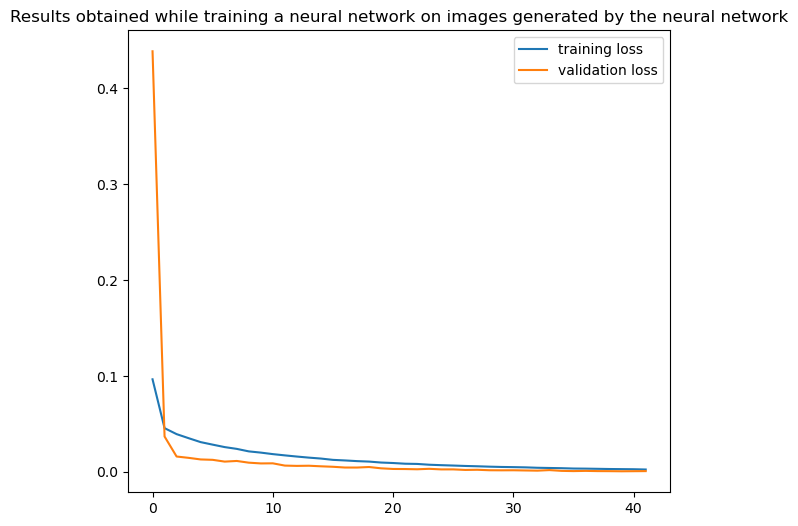

In [13]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

- Now, after training on the images generated by the generator, we will test the neural network on the basic images included in the dataset.

- We will use several measures in the evaluation to study what is the ability of the generative adversarial network to capture the basic features that characterize each class, and whether the second classified network extracted the features included in the generated images.
- Are the attributes that were extracted from the images generated by the generator, can be used on the original images included in the dataset.
- This helps in the ability to study what was actually generated, and whether the focus was really on the cases that the X-ray images made him have pneumonia or not.

In [83]:
m.evaluate(images, labels)

163/163 [==============================] - 2s 12ms/step - loss: 1.1623


1.1622899770736694

In [90]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

163/163 [==============================] - 2s 10ms/step


TensorShape([5216])

In [91]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [92]:
accuracy_score(y_pred, labels)*100

79.81211656441718

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [93]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support

           0       0.27      0.84      0.40       428
           1       0.98      0.79      0.88      4788

    accuracy                           0.80      5216
   macro avg       0.62      0.82      0.64      5216
weighted avg       0.92      0.80      0.84      5216



In [94]:
cm = confusion_matrix(y_pred, labels)
cm

array([[ 358,   70],
       [ 983, 3805]], dtype=int64)

In [95]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

NORMAL  PNEUMONIA
NORMAL        358         70
PNEUMONIA     983       3805

In [97]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 87.84485743968602, recall_score: 79.46950710108605, precision_score: 98.19354838709677


<Axes: >

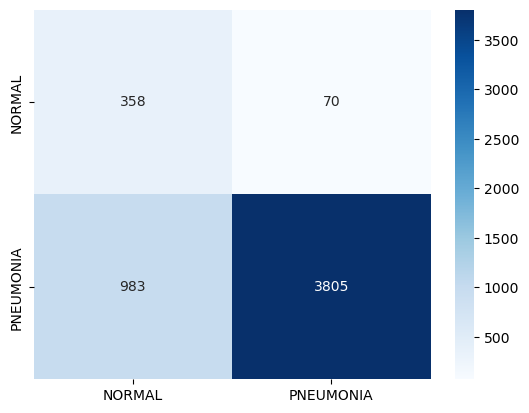

In [98]:
# Plotting heatmap for the confusion matrix
sns.heatmap(cmObject, annot = True, cmap="Blues", fmt = 'g')

- In the end, we can see that we have reached a neural network that is able to generate accurate images.
But the slight variation in the accuracy of the classification for each class is due to the fact that we need more training time for the generative adversarial network, which helps to focus more on the characteristics of each class (because the number of samples in the basic dataset is different for each class (the healthy case, pneumonia)).

In [99]:
# Compile the model
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
m.summary()

# Save the model
m.save('/kaggle/working/normal_pneumonia_classifier.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   